# Problema 1: Control PID de la Planta hidráulica


Como primer ejercicio, realizaremos un controlador PID (Proporcional Integral y Derivativo) sobre la hidroeléctrica. Un controlador tiene la finalidad de llevar el sistema a un punto de operación deseado, usualmente a este punto se llama referencia y en este caso la variable que deseamos manejar como referencia es la potencia de la turbina. El controlador PID realiza los cálculos necesarios para llevar el sistema hacia la referencia manejando su variable manipulada, en este caso la variable manipulada es la apertura de la compuerta. Es decir, este programa manipula la apertura de la compuerta para lograr la potencia de referencia definida.


En el siguiente código se implementa el controlador que nos permite fijar una referencia en la potencia (potencia que queremos alcanzar) y el programa controlara la apertura de la compuerta (variable manipulada) con la intención de alcanzar dicha referencia de potencia. Para poder modelar la planta, se ocupan las siguientes ecuaciones:

$$L=\frac{h}{\tan(\theta)}$$


$$V_{h}(t)=\frac{bh^{2}(t)}{2}+\frac{h^{3}(t)}{3}$$


$$\frac{dV_{h}}{dt}=bh(t)\frac{dh}{dt}+h^{2}(t)\frac{dh}{dt}=q_{in}-Cab_{1}\sqrt{gh(t)}$$


$$ P=\eta \gamma Cab_{1}\sqrt{h(t)}\left(h(t) + \frac{v_2^2}{2g}-64\cdot\frac{\mu L v_2}{\rho D^2 2g}\right) $$



Este controlador tiene un rango de operación de $0 [MW]$ a $80 [MW]$, mientras que la apertura de la compuerta puede ir de 0 metros a 10 metros. Para poder poner a prueba el controlador se establecen 3 referencias distintas las cuales se pueden variar de manera arbitraria (se pueden modificar) para mostrar la apertura de compuerta necesaria para alcanzar cierta potencia. La referencia 1 $Pref_1=10[MW]$ estará activa en el intervalo de tiempo $[0s-2s]$, la referencia 2 $Pref_2=50[MW]$ estará activa en el intervalo de tiempo $[2s-4s]$ mientras que la referencia 3 $Pref_3=20[MW]$ estará activa en el intervalo de tiempo $[4s-6s]$. En el grafico final veremos cómo cambia la dinámica de la potencia y la apertura de la compuerta para lograr las distintas potencias establecidas. Además se consideró $\theta=\frac{\pi}{4}$.






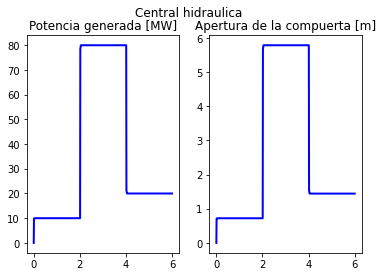

In [1]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import numpy
import math

# function that returns dy/dt
def model(z,t,qin,C,a,b1,g,Lt,b,mu,rho,D,hi):
    h=z[0]                                                #Funcion EDO
    Q = C*a*b1*math.sqrt(g*(hi+h))                        #Caudal de salida
    v_2 = 4*Q/(math.pi*D**2)                              #Velocidad de salida
    dhdt = (qin-Q)/(b*h+h**2) #EDO para altura
    return [dhdt]

#Referencias (Se pueden modificar):

Pref1 = 10000000   #10 MW
Pref2 = 80000000   #50 MW
Pref3 = 20000000   #20 MW

#Parametros de tiempo:
h0 = 155    #initial condition
Time = 6    #Tiempo de simulacion
dt = 0.01   #Periodo de muestreo
t = np.arange(Time+1)

#Parametros del embalse:
qin = 100+ 30*numpy.cos(2*math.pi/Time*dt*10)   #Caudal de entrada
C = 0.64    #Parametro 
a = 1       #Ancho de la compuerta
b1 = 0      #Apertura vertical de la compuerta
b1max = 10  #Apertura maxima vertical de la compuerta
b = 100     #Base de la seccion transversal del estanque
efic  = 0.9 #Eficiencia de la turbina
g = 9.81    #Aceleracion de gravedad
Lt = 200    #distancia a la que está la turbina por la tubería
Le = 150    #distancia de   
mu = 0.001  #mu del agua 
rho = 1000  #densidad del agua
D = 5       #diametro de la tuberia
hi = 20     #altura desde la base del embalse

#Parametros del controlador:
Kd = 0              #Ganancias del PID
Ki = 0.00000007  
Kp = 0.000000001 
Pref = Pref1        #Potencia de referencia del controlador [0MW-80MW]


#Vectores de informacion:
vector_potencias = [] 
vector_b1 = []
vector_h = []
vector_qin = []
vector_tiempo = []
vector_error = []

#Inician variables iniciales:
Pinicial = 0
hinicial = h0
bl = 0
error = Pref - Pinicial 
vector_potencias.append(Pinicial)
vector_h.append(hinicial)
vector_b1.append(b1)
vector_qin.append(qin)
vector_tiempo.append(0)
vector_error.append(error)
I = 0
k = 0

for i in numpy.arange(0,Time,dt):
    if i>2:
        if i>4:
            Pref = Pref3
        else:
            Pref =Pref2
    else:
        Pref = Pref1

    #Se define el caudal de entrada del embalse y el error:
    qin = 100 + 30*numpy.cos((2*math.pi/Time)*i*10) 
    error_old = error
    error = Pref - Pinicial

    #Se aplica el PID:
    P = Kp*error
    I = I+Ki*error
    D1 = Kd*(error-error_old)/dt
    b1 = P+I+D1

    #Se aplican limites fisicos de la compuerta:
    if b1>b1max:
        b1 = b1max
        
    elif b1<0:
        b1 = 0
        
    else:
        b1 = b1

    #Se calcula la EDO y guardan outputs de tiempo y altura:
    out = odeint(model,hinicial,[i,i+dt],args=(qin,C,a,b1,g,Lt,b,mu,rho,D,hi))
    vector_tiempo.append(i+dt)
    hinicial = out[:,0][-1]

    #Calculamos caudal, velocidad de salida y perdidas:
    Q = C*a*b1*math.sqrt(g*hi)
    v_2 = 4*Q/(math.pi*D**2)
    hf = 64*(mu/rho)*(Lt/D**2)*(v_2/(2*g))

    #Se calcula la potencia de la iteración:
    P = rho*g*Q*(hi+hinicial-(v_2**2/(2*g))-hf)
    P = efic*P
    Pinicial = P

    #Se guardan los vectores:
    vector_potencias.append(Pinicial) 
    vector_h.append(hinicial)
    vector_qin.append(qin)
    vector_b1.append(b1)
    vector_error.append(error)
    k=k+1

#Gráficos:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Central hidraulica')
ax1.plot(vector_tiempo,np.dot(vector_potencias,1/1000000),'b-',linewidth=2)
ax1.set_title("Potencia generada [MW]")
ax2.plot(vector_tiempo,vector_b1,'b-',linewidth=2)
ax2.set_title("Apertura de la compuerta [m]")
plt.show()

Es fácil ver que el controlador logra llegar a todas las potencias de referencia definidas en cada intervalo de tiempo. Luego, vemos que la forma de onda de la apertura de la compuerta es similar a la de la potencia, esto es dado a la ecuación de potencia que llegamos en nuestro modelo. Para esta misma simulación además es útil graficar la altura del embalse. También se establece como caudal de entrada una onda sinusoidal con valor medio $100[m^3/s]$ y amplitud $30[m^3/s]$:

## Gráficos:

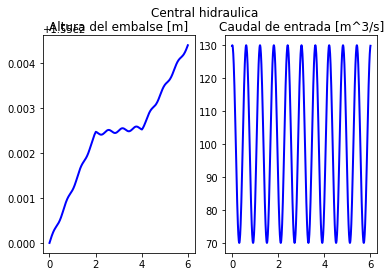

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('Central hidraulica')
ax1.plot(vector_tiempo,vector_h,'b-',linewidth=2)
ax1.set_title("Altura del embalse [m]")
ax2.plot(vector_tiempo,vector_qin,'b-',linewidth=2)
ax2.set_title("Caudal de entrada [m^3/s]")
plt.show()

Este ejercicio nos sirve para entender el modelo completo de la planta hidrauica y la dinamica que tiene este modelo en cuanto a los cambios de apertura de la compuerta.